In [15]:
# define imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import PIL
import os, random

from glob import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import display, Image
from IPython.core.display import HTML



import copy
#import cv2                

from io import open
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os, os.path, random
from PIL import Image
import requests
import shutil
import time

import torch
from torch.autograd import Variable
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms


%matplotlib inline


# my imports

from os import listdir
from os.path import isfile, join, abspath
from style_transfer.stylize import transfer


In [16]:
# All images are resized to 224x224 and normalized
# Only training images receive further augmentation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),    
}


In [17]:
data_dir = 'dogImages'
print(os.path.join(data_dir, 'valid'))


# we create some dictionaries
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
print(dataset_sizes)
class_names = image_datasets['train'].classes
n_classes = len(class_names)

#Check if gpu support is available
#cuda_avail = torch.cuda.is_available()

#device = torch.device("cuda:0" if cuda_avail else "cpu")
#print("Device:", device)

dogImages/valid
{'train': 59573, 'valid': 835, 'test': 836}


In [18]:
#import pandas as pd
import boto3
import sagemaker

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [ ]:
import os
# should be the name of directory you created to save your features data
data_dir = 'dogImages'
train_dir = 'train'

# set prefix, a descriptive name for a directory  
prefix = 'capstone-project'

# upload all data to S3
#test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

# upload data for the first time
train_location = sagemaker_session.upload_data(os.path.join(data_dir), key_prefix=prefix)
#train_location = 's3://{}/{}/'.format(bucket, prefix) 

In [ ]:
# your import and estimator code, here
from sagemaker.pytorch import PyTorch

output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='source_pytorch',
                    role=role,
                    framework_version='1.1.0',
                    train_instance_count=1,
                    #train_instance_type='ml.c4.xlarge',
                    train_instance_type='ml.p2.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    #env={'SAGEMAKER_REQUIREMENTS': 'requirements.txt'},
                    hyperparameters={
                        #'input_features': 4,  # num of features
                        #'hidden_dim': 20,
                        #'output_dim': 1,
                        'epochs': 10 # could change to higher
                    })



In [ ]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': train_location})
# estimator.fit()

2019-08-03 00:28:39 Starting - Starting the training job...
2019-08-03 00:28:40 Starting - Launching requested ML instances......
2019-08-03 00:29:41 Starting - Preparing the instances for training...
2019-08-03 00:30:29 Downloading - Downloading input data..........................................
2019-08-03 00:37:40 Training - Training image download completed. Training in progress..
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-08-03 00:37:42,006 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-08-03 00:37:42,033 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-08-03 00:37:45,053 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-08-03 00:37:45,360 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2019-08-03 00:37:45,360 sagemaker-containers INFO     Gener

In [21]:
%%time

# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

print(estimator.model_data)

# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.1.0',
                     entry_point='predict.py',
                     source_dir='source_pytorch')


# deploy your model to create a predictor


#transformer = model.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=output_path)

#transformer.transform(data=batch_input, data_type='S3Prefix', content_type='text/csv', split_type='Line')

#transformer.wait()


s3://sagemaker-eu-central-1-505649883860/capstone-project/sagemaker-pytorch-2019-08-03-01-04-33-845/output/model.tar.gz
CPU times: user 20.3 ms, sys: 0 ns, total: 20.3 ms
Wall time: 110 ms


In [22]:
# predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.large')



--------------------------------------------------------------------------------------!

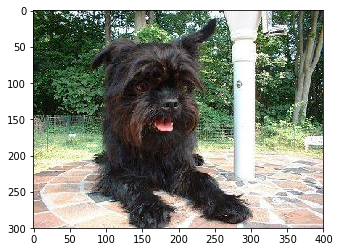

tensor([[[[-0.6794, -0.5082,  0.2111,  ..., -1.1247, -1.2959, -0.5767],
          [ 0.4851,  0.7419,  1.4612,  ..., -1.4158, -0.9192, -1.2103],
          [-0.6794,  1.3755,  1.5810,  ..., -1.0219, -1.2445, -1.2274],
          ...,
          [ 2.1290,  2.1119,  2.0948,  ...,  1.4269,  1.3584,  1.4269],
          [ 1.9749,  1.8893,  1.8379,  ...,  1.3584,  1.2728,  1.3070],
          [ 1.8379,  1.7352,  1.7009,  ...,  1.2899,  1.2899,  1.3242]],

         [[-0.0749,  0.0476,  0.7129,  ..., -0.3550, -0.5476,  0.1702],
          [ 1.1155,  1.2731,  1.9734,  ..., -0.6352, -0.1275, -0.4426],
          [-0.0749,  1.9384,  2.1134,  ..., -0.2150, -0.4251, -0.4251],
          ...,
          [ 2.0784,  2.0784,  2.0609,  ...,  1.4482,  1.3431,  1.4132],
          [ 1.8508,  1.7808,  1.7633,  ...,  1.2556,  1.1681,  1.1681],
          [ 1.6933,  1.5882,  1.5882,  ...,  1.0980,  1.1155,  1.1331]],

         [[ 0.2173,  0.4091,  1.1062,  ..., -0.8110, -0.7413,  0.2173],
          [ 1.3677,  1.5420,  

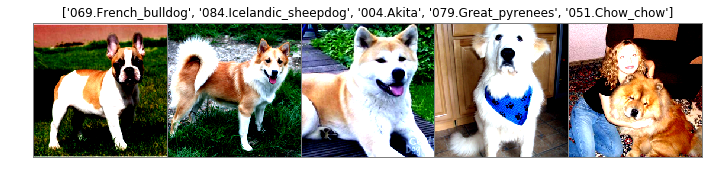

In [78]:
#import numpy as np
#test_y_preds = np.squeeze(np.round(predictor.predict(test_x)))

from PIL import Image, ImageFile
dog_image = Image.open('dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg')
plt.imshow(dog_image)
plt.show()


def image_to_tensor1(img_path):
    '''
    As per Pytorch documentations: All pre-trained models expect input images normalized in the same way, 
    i.e. mini-batches of 3-channel RGB images
    of shape (3 x H x W), where H and W are expected to be at least 224. 
    The images have to be loaded in to a range of [0, 1] and 
    then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
    You can use the following transform to normalize:
    '''
    img = Image.open(img_path).convert('RGB')
    transformations = data_transforms['train']
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)
    label = transformations(img).shape
    return image_tensor, label

#data_test_image_loader = dataloaders['train'].dataset[40][0][:3,:,:].unsqueeze(0)
data_test_image_loader, data_test_image_loader_label = image_to_tensor1('dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg')
#data_test_image_loader_label = dataloaders['train'].dataset[1500][1]
print(data_test_image_loader)
print(type(data_test_image_loader))

nparr = data_test_image_loader.cpu().numpy()



test_y_preds = predictor.predict(nparr)
print(f"printin {test_y_preds}")


# convert output probabilities to predicted class
use_cuda = torch.cuda.is_available()
_, preds_tensor = torch.max(torch.from_numpy(test_y_preds), 1)
pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
pred = int(pred)

class_description = get_human_readable_label_for_class_id(pred)
print(f'predicted label {pred} original label {data_test_image_loader_label}')





def imshow1(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    fig = plt.figure(figsize=(12,3))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow1(out, title=[class_names[x] for x in classes])

In [23]:
def test_acc(test_set, predictor):
    '''Calculates accuracy. Takes as input a PyTorch dataloader object containing images and labels.'''
    #model.eval()
    test_acc = 0.0
    running_corrects = 0

    # Iterate over data
    for inputs, classes in test_set:
        print(classes)
        test_y_preds = predictor.predict(inputs)

        _, preds_tensor = torch.max(torch.from_numpy(test_y_preds), 1)
        preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
        #pred = int(pred)
        print(f"preds is {preds}")
    
        running_corrects += torch.sum(torch.from_numpy(preds) == classes)

    test_acc = running_corrects.double() / len(test_set.dataset)

    print('Acc: {:.2f}%'.format(test_acc*100))

    return test_acc



use_cuda = torch.cuda.is_available()
testacc=test_acc(iter(dataloaders['test']), predictor)
print(testacc)

tensor([ 10, 102,  57,   8, 109])
preds is [ 10 102  57   8 117]
tensor([117,  69,  53,  13,  60])
preds is [117  69  53  13  76]
tensor([ 47,  41, 112, 117, 120])
preds is [ 47  41 112 117 120]
tensor([ 30,  51, 116,   4, 129])
preds is [ 30  51 116   4  84]
tensor([ 68,  22,  29,  41, 105])
preds is [ 68  22  29  41 105]
tensor([89, 62, 93, 98, 15])
preds is [89 60 93 99 15]
tensor([ 73, 127, 105,  17,  52])
preds is [ 25 127 105  17  52]
tensor([82, 60, 22, 27, 73])
preds is [82 60 22 27 73]
tensor([ 72,  58, 102,  86,  96])
preds is [25 17 40 86  2]
tensor([80, 12, 36, 23, 40])
preds is [80 12 36 23 40]
tensor([ 81,   3,  57, 105,  23])
preds is [ 99   3  57 105  23]
tensor([43, 24, 83, 86, 32])
preds is [43 24 83 86 32]
tensor([45, 15, 31, 12,  5])
preds is [45 15 31 12  5]
tensor([124,  73,  20,  14,   7])
preds is [124  92  20  14   7]
tensor([ 7, 31, 46, 42, 13])
preds is [ 7 31 46 42 42]
tensor([106,  34,  18,  37,  71])
preds is [106  65  18  37  95]
tensor([ 96,  40,  26, 11

preds is [ 10  22  13  46 122]
tensor([ 77,  40,  75,  33, 101])
preds is [77 40 75 33 69]
tensor([ 41, 124,  19,  41,  87])
preds is [110 124  19  41   8]
tensor([ 50,  30,  23, 123,  98])
preds is [ 50  30  23 123  98]
tensor([ 86,  77, 100,   7,  62])
preds is [ 86  40 100   7  19]
tensor([ 12,   4,  60,   5, 116])
preds is [ 12   4  62   5 116]
tensor([108,  80, 119,  49,  58])
preds is [ 66  80 119  49  58]
tensor([ 46,  43, 116,  56,  14])
preds is [ 46   7 116  56  14]
tensor([83, 46, 82, 37, 38])
preds is [83 46 82 37 38]
tensor([ 86, 108,  25,  38,  64])
preds is [ 86 108  25  38  64]
tensor([ 18,  60,  45, 117, 131])
preds is [ 18  60  76 117 131]
tensor([99, 34, 15, 56, 58])
preds is [99 34 15 56 58]
tensor([111,  33,  55,  85,  10])
preds is [111  33  55  85  10]
tensor([  2, 114, 127,  57, 126])
preds is [  2 114  80  57 132]
tensor([58, 14, 70, 79, 90])
preds is [69 14 70 79 90]
tensor([46, 18, 37, 66, 61])
preds is [46 18 37 66 61]
tensor([80, 38, 14,  9, 65])
preds is [

In [23]:
print(f"No. of Training Records: {dataset_sizes['train']}")
print(f"No. of Validation Records: {dataset_sizes['valid']}")
print(f"No. of Testing Records: {dataset_sizes['test']}")
      

# Preview a record (input, label) from the training set. 
# -- Image pixel values should be normalized. Label value should be an integer between 0 and 133.


print(dataloaders['train'].dataset[1500])
#print(dataloaders['train'].dataset[1500][0]) only the data vector

data_test_image_loader = dataloaders['train'].dataset[1500][0][:3,:,:].unsqueeze(0)
print(data_test_image_loader)
print(classes)

NameError: name 'dataset_sizes' is not defined

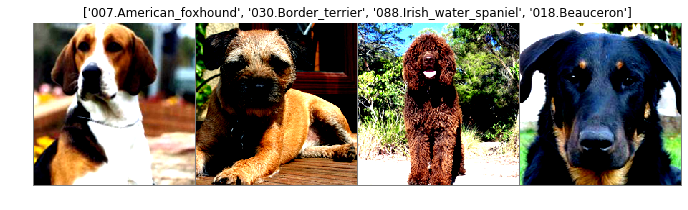

In [137]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    fig = plt.figure(figsize=(12,3))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [57]:
from PIL import Image, ImageFile
dog_image = Image.open('dogImages1/train/001.Affenpinscher/Affenpinscher_00001.jpg')
plt.imshow(dog_image)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'dogImages1/train/001.Affenpinscher/Affenpinscher_00001.jpg'

In [139]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    image_tensor = image_to_tensor(img_path)
   
    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = VGG16(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
 

    return int(pred)


def ResNet50_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    image_tensor = dataloaders['train'].dataset[1500][0][:3,:,:].unsqueeze(0) #image_to_tensor(img_path)
   
    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = ResNet50(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
 

    return int(pred)

In [48]:
# import requests
import ast

LABELS_MAP_URL = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/c2c91c8e767d04621020c30ed31192724b863041/imagenet1000_clsid_to_human.txt"

# maps the output label from the pretrained VGG16 model to the human readable classe
def get_human_readable_label_for_class_id(class_id):
    labels = ast.literal_eval(requests.get(LABELS_MAP_URL).text)
    print(f"Label:{labels[class_id]}")
    return labels[class_id]
    
# Beachte: Das VGG16 Modell wurde lediglich mit pretrained Gewichten eingeladen. Das letzte
# Layer wurde jedoch nicht nochmals traineirt o.ä.
test_prediction = VGG16_predict('dogImages1/train/001.Affenpinscher/Affenpinscher_00002.jpg')
pred_class = int(test_prediction)

print(f"Predicted class id: {pred_class}")
class_description = get_human_readable_label_for_class_id(pred_class)
#print(f"Predicted class for image is *** {class_description.upper()} ***")


test_prediction = ResNet50_predict('dogImages1/train/001.Affenpinscher/Affenpinscher_00002.jpg')
pred_class = int(test_prediction)

print(f"Predicted class id: {pred_class}")
class_description = get_human_readable_label_for_class_id(pred_class)


NameError: name 'VGG16_predict' is not defined

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    prediction = VGG16_predict(img_path)
#     print(prediction)
    return ((prediction >= 151) & (prediction <=268))

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)


### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [28]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    
    valid_loss_min = np.Inf # 3.877533
    
    if os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in loaders['train']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in loaders['valid']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
    
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
             # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


# train the model
model_scratch = train(15, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.327389 	Validation Loss: 4.549846
Validation loss decreased (inf --> 4.549846).  Saving model ...
Epoch: 2 	Training Loss: 4.214001 	Validation Loss: 4.519890
Validation loss decreased (4.549846 --> 4.519890).  Saving model ...
Epoch: 3 	Training Loss: 4.115721 	Validation Loss: 4.478468
Validation loss decreased (4.519890 --> 4.478468).  Saving model ...
Epoch: 4 	Training Loss: 4.018137 	Validation Loss: 4.492744
Epoch: 5 	Training Loss: 3.913435 	Validation Loss: 4.498920
Epoch: 6 	Training Loss: 3.825028 	Validation Loss: 4.413985
Validation loss decreased (4.478468 --> 4.413985).  Saving model ...
Epoch: 7 	Training Loss: 3.714839 	Validation Loss: 4.351671
Validation loss decreased (4.413985 --> 4.351671).  Saving model ...
Epoch: 8 	Training Loss: 3.609758 	Validation Loss: 4.355868
Epoch: 9 	Training Loss: 3.501825 	Validation Loss: 4.472732
Epoch: 10 	Training Loss: 3.396894 	Validation Loss: 4.061569
Validation loss decreased (4.351671 --> 4.061569)

In [142]:
#### MY TRAINING
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    
    valid_loss_min = np.Inf # 3.877533
    
    if os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in dataloaders['train']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in dataloaders['valid']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
    
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(dataloaders['train'].dataset)
        valid_loss = valid_loss/len(dataloaders['valid'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
         # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


# train the model
#model_scratch = train(15, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# takes very long because no weight freezing!!!
#model_scratch = train(15, dataloaders, ResNet50, optimizer_resnet50, criterion, use_cuda, 'model_resnet50.pt')


# load the model that got the best validation accuracy
#model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [29]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.939793


Test Accuracy: 10% (84/836)


In [143]:
### MY TEST
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
#test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [30]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch
print(loaders_transfer)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fa8686d2630>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x7fa8686d2668>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7fa8686d2550>}


In [166]:
loaders_transfer = dataloaders

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [162]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [163]:
# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False
# Replace the last fully connected layer with a Linnear layer with 133 out features
model_transfer.fc = nn.Linear(2048, 133)
if use_cuda:
    model_transfer = model_transfer.cuda()

In [144]:
# MY FREEZE


######
# define ResNet50 model
ResNet50 = models.resnet50(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in ResNet50.parameters():
    param.requires_grad = False

# to be able to switch out the last layer, we first need to know the shape,
# so that the dimensions are the same
in_features = ResNet50.fc.in_features

# our transfer learning algorithm will cut out the last layer
# and retrain it on our data
ResNet50.fc = nn.Linear(in_features, n_classes)

# move model to GPU if CUDA is available
if use_cuda:
    ResNet50 = ResNet50.cuda()

In [146]:
# MY LOSS & OPTI
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimization + learning rate. Note that all parameters are being optimized.
optimizer_resnet50 = optim.Adam(ResNet50.fc.parameters(), lr=0.001) #optim.SGD(ResNet50.parameters(), lr=0.001, momentum=0.9)

# Regularization. Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_resnet50, step_size=7, gamma=0.1)


#alternativ
#criterion_transfer = nn.CrossEntropyLoss()
#optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

In [164]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [147]:
# TRAIN MY TRANSFER MODEL

# Fix for cuda error resulting from truncated images
# https://stackoverflow.com/a/23575424/7434289

from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

model_resnet50_transfer = train(15, dataloaders, ResNet50, optimizer_resnet50, criterion, use_cuda, 'model_resnet50.pt')


Epoch: 1 	Training Loss: 2.833416 	Validation Loss: 1.194638
Validation loss decreased (inf --> 1.194638).  Saving model ...
Epoch: 2 	Training Loss: 1.660292 	Validation Loss: 0.964107
Validation loss decreased (1.194638 --> 0.964107).  Saving model ...
Epoch: 3 	Training Loss: 1.544237 	Validation Loss: 0.958138
Validation loss decreased (0.964107 --> 0.958138).  Saving model ...
Epoch: 4 	Training Loss: 1.380623 	Validation Loss: 1.234579
Epoch: 5 	Training Loss: 1.371371 	Validation Loss: 0.927222
Validation loss decreased (0.958138 --> 0.927222).  Saving model ...
Epoch: 6 	Training Loss: 1.353999 	Validation Loss: 1.045329
Epoch: 7 	Training Loss: 1.304986 	Validation Loss: 0.942591
Epoch: 8 	Training Loss: 1.203666 	Validation Loss: 1.279559
Epoch: 9 	Training Loss: 1.266139 	Validation Loss: 1.028015
Epoch: 10 	Training Loss: 1.107529 	Validation Loss: 1.208653
Epoch: 11 	Training Loss: 1.168009 	Validation Loss: 1.114716
Epoch: 12 	Training Loss: 1.129242 	Validation Loss: 1.3

In [167]:
# train the model
model_transfer = train(15, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch: 1 	Training Loss: 2.917847 	Validation Loss: 0.932368
Validation loss decreased (inf --> 0.932368).  Saving model ...


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kmaier/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/kmaier/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/kmaier/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/kmaier/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/kmaier/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/Users/kmaier/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/kmaier/anaconda3/lib/python3.7/multiprocessing/connectio

KeyboardInterrupt: 

In [35]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [36]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.672487


Test Accuracy: 82% (689/836)


In [151]:
# MY BEST MODEL
# load the model that got the best validation accuracy (uncomment the line below)
model_resnet50_transfer.load_state_dict(torch.load('model_resnet50.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [152]:
# MY TEST
test(dataloaders, model_resnet50_transfer, criterion, use_cuda)
#model_resnet50_transfer = train(15, dataloaders, ResNet50, optimizer_resnet50, criterion, use_cuda, 'model_resnet50.pt')



Test Loss: 0.935130


Test Accuracy: 79% (663/836)


In [121]:
def ResNet50_transfer_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    image_tensor =  dataloaders['train'].dataset[1526][0][:3,:,:].unsqueeze(0) # image_to_tensor(img_path) #
   
    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = model_resnet50_transfer(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
 

    return int(pred)


test_prediction = ResNet50_predict('dogImages1/train/001.Affenpinscher/Affenpinscher_00002.jpg')
pred_class = int(test_prediction)

print(f"Predicted class id: {pred_class}")
class_description = get_human_readable_label_for_class_id(pred_class)


test_prediction = ResNet50_transfer_predict('dogImages1/train/001.Affenpinscher/Affenpinscher_00002.jpg')
pred_class = int(test_prediction)

print(f"Predicted class id: {pred_class}")
class_description = get_human_readable_label_for_class_id(pred_class)

Predicted class id: 119
Label:rock crab, Cancer irroratus
Predicted class id: 78
Label:tick


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [93]:
print(image_datasets['train'].classes)

['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog', '044.Cane_corso', '045.Cardigan_welsh_

In [37]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in  image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image_tensor = image_to_tensor(img_path)

    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = model_transfer(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]

In [38]:
def display_image(img_path, title="Title"):
    image = Image.open(img_path)
    plt.title(title)
    plt.imshow(image)
    plt.show()

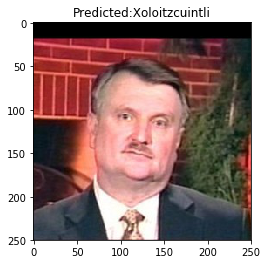

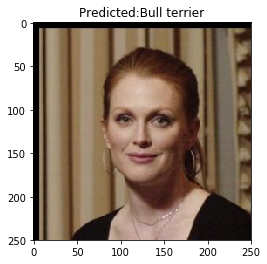

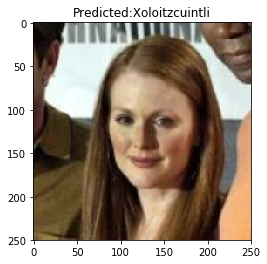

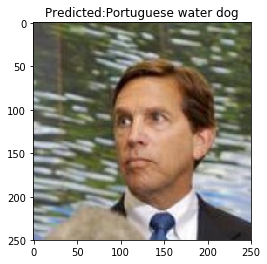

In [39]:
import random

# Try out the function
for image in random.sample(list(human_files_short), 4): 
    predicted_breed = predict_breed_transfer(image)
    display_image(image, title=f"Predicted:{predicted_breed}")

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [42]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    # check if image has juman faces:
    if (face_detector(img_path)):
        print("Hello Human!")
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title=f"Predicted:{predicted_breed}")
        
        print("You look like a ...")
        print(predicted_breed.upper())
    # check if image has dogs:
    elif dog_detector(img_path):
        print("Hello Doggie!")
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title=f"Predicted:{predicted_breed}")
        
        print("Your breed is most likley ...")
        print(predicted_breed.upper())
    else:
        print("Oh, we're sorry! We couldn't detect any dog or human face in the image.")
        display_image(img_path, title="...")
        print("Try another!")
    print("\n")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

Hello Human!


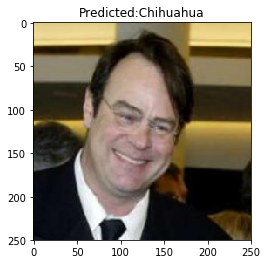

You look like a ...
CHIHUAHUA


Hello Human!


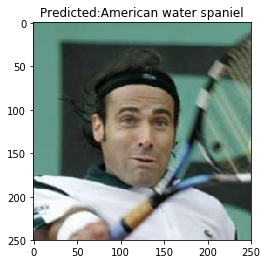

You look like a ...
AMERICAN WATER SPANIEL


Hello Human!


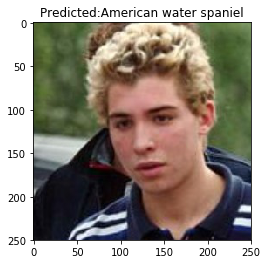

You look like a ...
AMERICAN WATER SPANIEL


Hello Doggie!


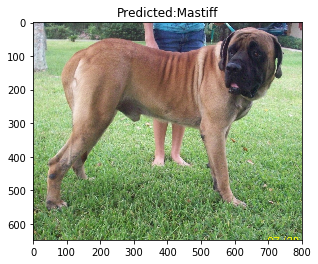

Your breed is most likley ...
MASTIFF


Hello Doggie!


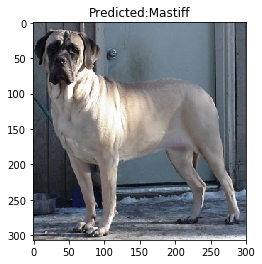

Your breed is most likley ...
MASTIFF


Hello Doggie!


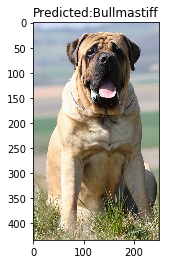

Your breed is most likley ...
BULLMASTIFF




In [43]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)